In [1]:
import numpy as np;
import networkx as nx;
import pandas as pd;
import matplotlib.pyplot as plt;
import math;

## Reading the network data

The yeast network was already used previously...

In [6]:
yeast_net = nx.read_edgelist('yeastinter_st.txt',data = False);       # we ignore the 3rd column in the file

The other network is the social network between FIFA leaders based on commitee co-memberships.

Although we have learned that sparse networks should be better stored as link lists, this network is publicly available in a matrix format...

First we just peek into the data using pandas:

In [2]:
pd.read_csv('2015_FIFA_1M.csv',sep = ',',index_col=0)

,ABDULLAH Prince H.R.H,ABEGA Prosper,ABO RIDA Hany,ACHE Eduardo,ACKERMANN Nair,ACOSTA Francisco,ADAMS Mark,ADOUM Djibrine,AGHAZADA Sayed,AHMAD Ahmad,...,WILKINSON Rhian,WILLIAMSON Stephen,WINDTNER Leo,WONUHALI Linda,WOODSON Rochell,YAHYA Ahmed,ZAMBRANO Jose,ZAW Zaw,ZERGUINI Yacine,ZHANG Jian
ABDULLAH Prince H.R.H,4,0,2,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ABEGA Prosper,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABO RIDA Hany,2,0,4,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ACHE Eduardo,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACKERMANN Nair,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YAHYA Ahmed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
ZAMBRANO Jose,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
ZAW Zaw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
ZERGUINI Yacine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


And now we actually read the matrix into a pandas dataframe, which can then converted into a network by networkx.

In [3]:
FIFA_df = pd.read_csv('2015_FIFA_1M.csv',sep = ',',index_col=0);
FIFA_net = nx.convert_matrix.from_pandas_adjacency(FIFA_df);

Let's look at the basic network properties of the two networks:

In [7]:
print('yeast net N =',yeast_net.number_of_nodes(),', L =',yeast_net.number_of_edges());
print('yeast net max. degree = ',max([yeast_net.degree(node) for node in yeast_net.nodes]));
print();
print('FIFA net N =',FIFA_net.number_of_nodes(),', L =',FIFA_net.number_of_edges());
print('yeast net max. degree = ',max([FIFA_net.degree(node) for node in FIFA_net.nodes]));

yeast net N = 688 , L = 1078
yeast net max. degree =  71

FIFA net N = 450 , L = 5472
yeast net max. degree =  117


## Preparing the E and e matrices

A straight forward approach to study the degree correlations in a network is offered by the **E** matrix, in which rows and collumns correspond to the possible node degrees in the network from 1 to $k_{\rm max}$, and $E_{k_1,k_2}$ is simply the number of connected node pairs where the degree of the first node is $k_1$ and the degree of the second node is $k_2$. (The diagonal elements $E_{kk}$ correspond to twice the number of links between nodes of the same degree $k$ in order to treet all links and degree pairings in a fair manner). Since every link in the network contributes to **E** twice, the sum of all entries is $\sum_{i,j}E_{k_i,k_j}=2L$, where $L$ is the total number of links. 

The **e** matrix is simply the **E** matrix, where we divide all entries by $2L$.  This way the sum of the elements in **e** is equal to 1.

We prepare a function calculating the **E** and **e** matrices:

In [8]:
def Prepare_Ee_matrices(network):
    max_degree = max([network.degree(node) for node in network.nodes]);   # the maximum degree in the network.
    E_matr = np.zeros(shape = (max_degree+1,max_degree+1),dtype = int);   # a matrix full of zeros.
    for node1 in network.nodes:
        k1 = network.degree(node1);
        for node2 in network.neighbors(node1):
            k2 = network.degree(node2);                                   # note that no 'extra' care is needed
            E_matr[k1,k2] += 1;                                           # for the diagonal elements.
            
    e_matr = np.zeros(shape = (max_degree+1,max_degree+1),dtype = float);
    for k1 in range(0,max_degree+1):
        for k2 in range(0,max_degree+1):
            e_matr[k1,k2] = E_matr[k1,k2]/(2.0*network.number_of_edges());
    return E_matr,e_matr;

First let's try it out on the yeast network.

In [9]:
yeast_E_matr,yeast_e_matr = Prepare_Ee_matrices(yeast_net);

Let's have a look at basic properties of the **E** matrix:

In [10]:
print('yeast E matrix shape:',yeast_E_matr.shape);
print('yeast E matr.:\n',yeast_E_matr);
print('yeast E matr. sum:',sum(sum(yeast_E_matr)));

yeast E matrix shape: (72, 72)
yeast E matr.:
 [[ 0  0  0 ...  0  0  0]
 [ 0 12 12 ...  0  0 23]
 [ 0 12  8 ...  0  0 35]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0 23 35 ...  0  0  0]]
yeast E matr. sum: 2156


Same for the **e** matrix:

In [11]:
print('yeast e matrix shape:',yeast_e_matr.shape);
print('yeast e matr.:\n',yeast_e_matr);
print('yeast e matr. sum:',sum(sum(yeast_e_matr)));

yeast e matrix shape: (72, 72)
yeast e matr.:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00556586 0.00556586 ... 0.         0.         0.0106679 ]
 [0.         0.00556586 0.00371058 ... 0.         0.         0.01623377]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.0106679  0.01623377 ... 0.         0.         0.        ]]
yeast e matr. sum: 1.0000000000000002


Seems to work fine, let's prepare the matrices for the FIFA network as well.

In [12]:
FIFA_E_matr,FIFA_e_matr = Prepare_Ee_matrices(FIFA_net);

## Heatmap from the E and e matrices

Luckily, it is very easy to make a 2d heatmap of the matrices using pyplot.

<Figure size 432x288 with 0 Axes>

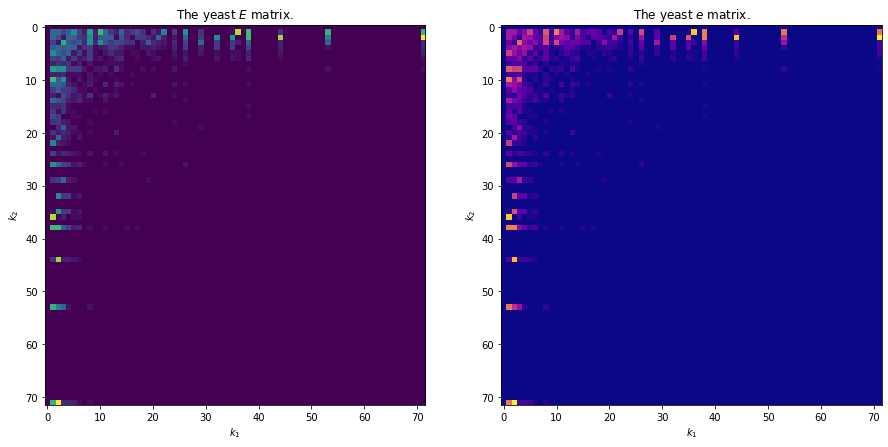

In [14]:
plt.clf();
f, axs = plt.subplots(2,2,figsize=(15,10))
plt.subplot(121);
plt.imshow(yeast_E_matr,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The yeast $E$ matrix.')
#plt.colorbar();

plt.subplot(122);
plt.imshow(yeast_e_matr,cmap = 'plasma');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The yeast $e$ matrix.')
#plt.colorbar();
plt.show();

Actually, it is much more interesting to compare the **e** matrices for the yeast and the FIFA network:

<Figure size 432x288 with 0 Axes>

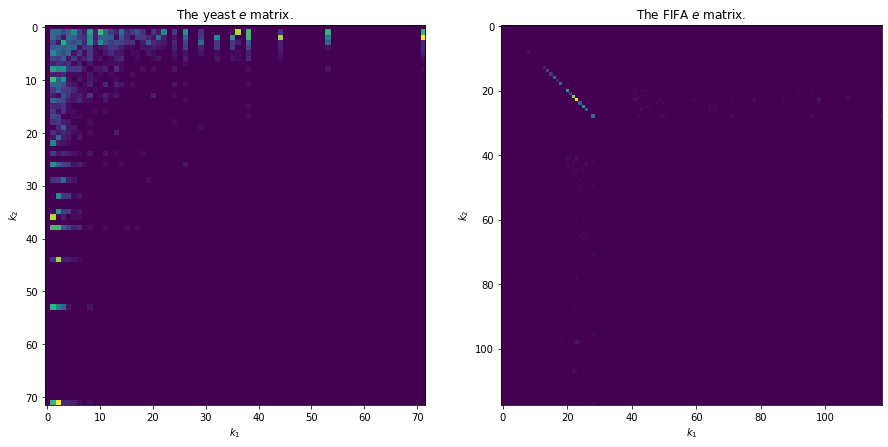

In [17]:
plt.clf();
f, axs = plt.subplots(2,2,figsize=(15,10))
plt.subplot(121);
plt.imshow(yeast_e_matr,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The yeast $e$ matrix.')
#plt.colorbar();

plt.subplot(122);
plt.imshow(FIFA_e_matr,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The FIFA $e$ matrix.')
#plt.colorbar();
plt.show();

## Calculating the neutral e matrix

The **e** matrix corresponding to a neutral network with the same size and degree distribution can be obtained by first calculating the row (or column) sums $q_i = \sum_j e_{ij}$ and then preparing a matrix where the entries are simply the products of the corresponding $q$ values, i.e., $$e^{\rm (neut)}_{ij} =q_i\cdot q_j$$

In [35]:
def Prepare_neutral_matrix(network):
    max_degree = max([network.degree(node) for node in network.nodes]);   # the maximum degree in the network.
    E_matr = np.zeros(shape = (max_degree+1,max_degree+1),dtype = int);   # a matrix full of zeros.
    for node1 in network.nodes:
        k1 = network.degree(node1);
        for node2 in network.neighbors(node1):
            k2 = network.degree(node2);                                   # note that no 'extra' care is needed
            E_matr[k1,k2] += 1;                                           # for the diagonal elements.
            
    e_matr = np.zeros(shape = (max_degree+1,max_degree+1),dtype = float);
    for k1 in range(0,max_degree+1):
        for k2 in range(0,max_degree+1):
            e_matr[k1,k2] = E_matr[k1,k2]/(2.0*network.number_of_edges());
    
    q_i = np.zeros(shape = (max_degree+1,), dtype = float);
    for k1 in range(0,max_degree+1):
        for k2 in range(0,max_degree+1):
            q_i[k1] += e_matr[k1,k2];
    
    q_j = np.zeros(shape = (max_degree+1,), dtype = float);
    for k1 in range(0,max_degree+1):
        for k2 in range(0,max_degree+1):
            q_j[k2] += e_matr[k2,k1];
    
    e_matr_neutral = np.zeros(shape = (max_degree+1,max_degree+1),dtype = float);
    for k1 in range(0,max_degree+1):
        for k2 in range(0,max_degree+1):
            e_matr_neutral[k1][k2] = q_i[k1]*q_j[k2];
    
    return e_matr_neutral

In [36]:
FIFA_e_matr_neutral = Prepare_neutral_matrix(FIFA_net);

In [37]:
print('neutral e matrix shape:',FIFA_e_matr_neutral.shape);
print('neutral e matr.:\n',FIFA_e_matr_neutral);
print('neutral e matr. sum:',sum(sum(FIFA_e_matr_neutral)));

neutral e matrix shape: (118, 118)
neutral e matr.:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.00011235]]
neutral e matr. sum: 0.9194538824445984


<Figure size 432x288 with 0 Axes>

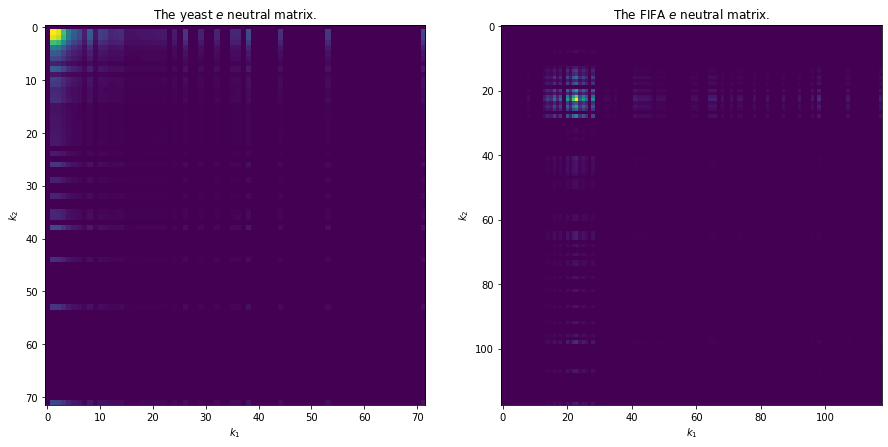

In [42]:
plt.clf();
f, axs = plt.subplots(2,2,figsize=(15,10))
plt.subplot(121);
plt.imshow(yeast_e_matr_neutral,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The yeast $e$ neutral matrix.')
#plt.colorbar();

plt.subplot(122);
plt.imshow(FIFA_e_matr_neutral,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The FIFA $e$ neutral matrix.')
#plt.colorbar();
plt.show();

In [40]:
yeast_e_matr_neutral = Prepare_neutral_matrix(yeast_net);

<Figure size 432x288 with 0 Axes>

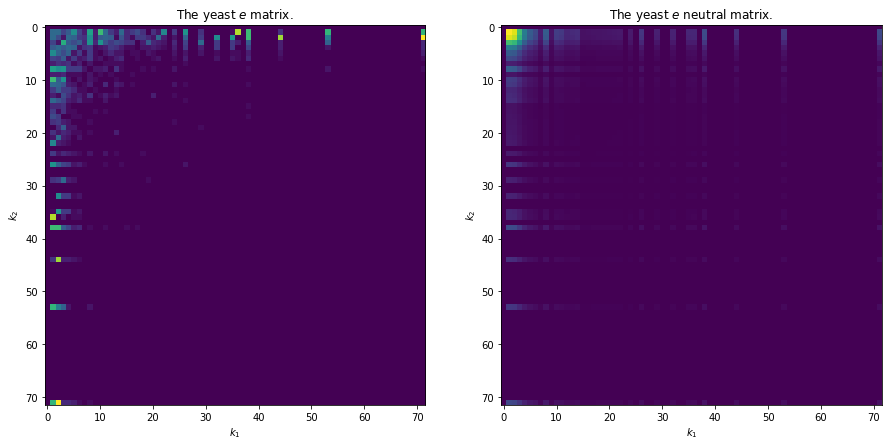

In [43]:
plt.clf();
f, axs = plt.subplots(2,2,figsize=(15,10))
plt.subplot(121);
plt.imshow(yeast_e_matr,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The yeast $e$ matrix.')
#plt.colorbar();

plt.subplot(122);
plt.imshow(yeast_e_matr_neutral,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The yeast $e$ neutral matrix.')
#plt.colorbar();
plt.show();

<Figure size 432x288 with 0 Axes>

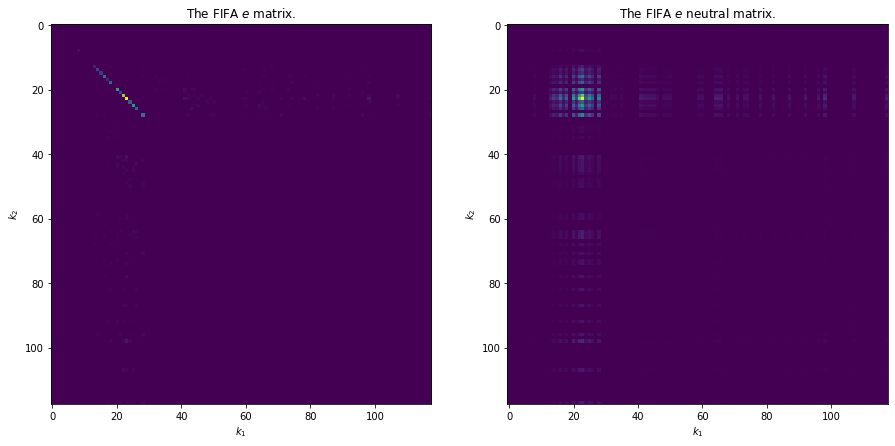

In [44]:
plt.clf();
f, axs = plt.subplots(2,2,figsize=(15,10))
plt.subplot(121);
plt.imshow(FIFA_e_matr,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The FIFA $e$ matrix.')
#plt.colorbar();

plt.subplot(122);
plt.imshow(FIFA_e_matr_neutral,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The FIFA $e$ neutral matrix.')
#plt.colorbar();
plt.show();